In [3]:
import json

with open('data.json', 'r') as file:
    data = json.load(file)

display(len(data))

1290

In [4]:
from collections import defaultdict

def profile(history):
    counts = defaultdict(int)
    for j in range(len(history)):
        for k in range(10):
            icon = history[j]["participants"][k]["profileIcon"]
            counts[icon] += 1
    return max(counts, key=counts.get)

In [5]:
import json
import tensorflow as tf

with open('structure.json', 'r') as file:
    structure = json.load(file)

dataset = []

for i in range(len(data)): # History
    history = []
    icon = profile(data[i])
    for j in range(len(data[i])): # Game
        game = []
        players = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        for k in range(5, 10):
            if data[i][j]["participants"][k]["profileIcon"] == icon:
                players = [5, 6, 7, 8, 9, 0, 1, 2, 3, 4]
        for k in players: # Participant
            for key, value in structure.items():
                if len(value) == 0:
                    game.append(data[i][j]["participants"][k][key])
                else:
                    game.append(value.index(data[i][j]["participants"][k][key]))
        history.append(game)
    dataset.append(history)

dataset = tf.ragged.constant(dataset, ragged_rank=1, dtype=tf.float32)

mean = tf.math.reduce_mean(dataset, axis=[0, 1], keepdims=True)
deviation = tf.math.reduce_std(dataset, axis=[0, 1], keepdims=True)

dataset = (dataset - mean) / deviation

train, test = tf.split(dataset, [1090, 200])
display(train.shape, test.shape)

TensorShape([1090, None, 800])

TensorShape([200, None, 800])

In [2]:
from tensorflow import keras
from keras import layers

model = keras.Sequential([
    layers.InputLayer((None, 800)),
    layers.Dense(1024),
    layers.LSTM(512, return_sequences=True),
    layers.Dense(800)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, None, 1024)        820224    
                                                                 
 lstm_1 (LSTM)               (None, None, 512)         3147776   
                                                                 
 dense_3 (Dense)             (None, None, 800)         410400    
                                                                 
Total params: 4378400 (16.70 MB)
Trainable params: 4378400 (16.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
from keras import losses, backend as K

class LossOfLegends(losses.Loss):
    def __init__(self, weights):
        self.weights = weights
        super().__init__()
    def call(self, value, prediction):
        return K.mean(K.sum(K.square(value - prediction) * self.weights, axis=-1))

In [6]:
weights = []

for key, value in structure.items():
    if key == 'win':
        weights.append(0.08)
    else:
        weights.append(0.02 / 79)

weights = tf.constant(10 * weights)

display(weights.shape, sum(weights))

TensorShape([800])

<tf.Tensor: shape=(), dtype=float32, numpy=0.99999195>

In [9]:
import tensorflow as tf

def accuracy(value, prediction):
    value = tf.greater(value[:, 79], 0)
    prediction = tf.greater(prediction[:, 79], 0)
    
    accuracy = tf.reduce_mean(tf.cast(tf.equal(value, prediction), tf.float32))
    
    return accuracy

In [45]:
model.compile(loss=LossOfLegends(weights), metrics=accuracy)
history = model.fit(train[:, :-1], train[:, 1:], validation_data=(test[:, :-1], test[:, 1:]), epochs=15)

Epoch 1/15
35/35 [==============================] - 28m 48s/step - loss: 1.0001 - accuracy: 0.4959 - val_loss: 1.0012 - val_accuracy: 0.4788
Epoch 2/15
35/35 [==============================] - 25m 43s/step - loss: 0.9999 - accuracy: 0.5496 - val_loss: 1.0011 - val_accuracy: 0.5043
Epoch 3/15
35/35 [==============================] - 25m 43s/step - loss: 0.9995 - accuracy: 0.5822 - val_loss: 1.0009 - val_accuracy: 0.5681
Epoch 4/15
35/35 [==============================] - 26m 44s/step - loss: 0.9984 - accuracy: 0.6276 - val_loss: 0.9992 - val_accuracy: 0.5983
Epoch 5/15
35/35 [==============================] - 26m 45s/step - loss: 0.9966 - accuracy: 0.6450 - val_loss: 0.9985 - val_accuracy: 0.6242
Epoch 6/15
35/35 [==============================] - 28m 48s/step - loss: 0.9945 - accuracy: 0.6578 - val_loss: 0.9964 - val_accuracy: 0.6407
Epoch 7/15
35/35 [==============================] - 26m 44s/step - loss: 0.9917 - accuracy: 0.6681 - val_loss: 0.9944 - val_accuracy: 0.6592
Epoch 8/15
35

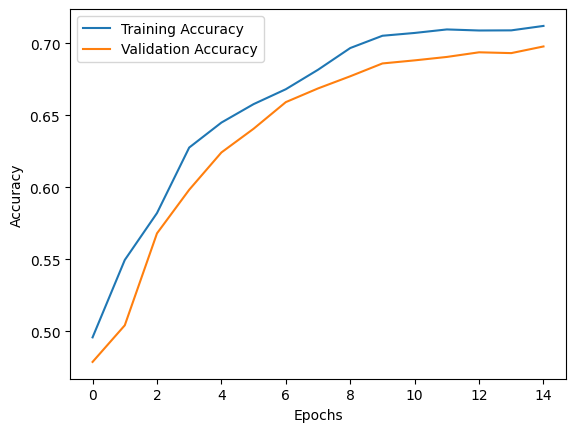

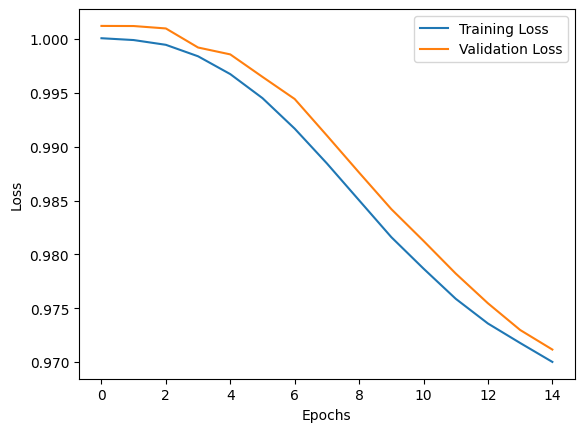

In [57]:
from matplotlib import pyplot

def plot(history, metric):
    pyplot.plot(history.history[metric])
    pyplot.plot(history.history['val_'+metric])
    pyplot.xlabel("Epochs")
    pyplot.ylabel(metric.capitalize())
    pyplot.legend([f"Training {metric.capitalize()}", f"Validation {metric.capitalize()}"])
    pyplot.show()

plot(history, 'accuracy')
plot(history, 'loss')

In [ ]:
with open('model.json', 'w') as file:
    file.write(model.to_json())
model.save_weights("model.keras")
tf.io.write_file("mean.tfrecord", tf.io.serialize_tensor(mean))
tf.io.write_file("deviation.tfrecord", tf.io.serialize_tensor(deviation))